In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

In [7]:
FNAME = 'data.csv'

In [8]:
def str_to_datetime(s: str, format: str='%Y-%m-%d_%H-%M-%S') -> datetime:
    return datetime.strptime(s, format)

def str_to_epoch(s: str, format: str='%Y-%m-%d_%H-%M-%S') -> float:
    dt = str_to_datetime(s)
    return dt.timestamp()

In [9]:
data_pd = pd.read_csv(FNAME, sep=',')
data_pd['datetime'] = data_pd['time'].apply(str_to_datetime)
data_pd['epoch'] = data_pd['time'].apply(str_to_epoch)
n_balanzas = len([c for c in data_pd.columns if 'balanza_std' in c])
print('n_balanzas:', n_balanzas)
data_pd.head()

n_balanzas: 2


,time,balanza_avg_1,balanza_std_1,balanza_pump_state_1,n_filtered_1,grams_goals_1,grams_threshold_1,balanza_avg_2,balanza_std_2,balanza_pump_state_2,n_filtered_2,grams_goals_2,grams_threshold_2,n_unsuccessful,hum,temp,datetime,epoch
0,2024-03-08_17-58-21,574.778126,1.011996,1,1,660,5.0,583.004373,1.023574,1,1,613,5.0,0,48.0,23.6,2024-03-08 17:58:21,1.709932e+09
1,2024-03-08_17-58-56,574.764989,1.011968,1,0,660,5.0,584.800771,1.026717,1,0,613,5.0,0,48.6,23.8,2024-03-08 17:58:56,1.709932e+09
2,2024-03-08_17-59-32,576.538181,1.015089,1,1,660,5.0,586.477021,1.029635,1,0,613,5.0,0,50.0,23.8,2024-03-08 17:59:32,1.709932e+09
3,2024-03-08_18-00-08,576.537276,1.015087,1,1,660,5.0,586.441917,1.029599,1,0,613,5.0,0,52.2,23.9,2024-03-08 18:00:08,1.709932e+09
4,2024-03-08_18-02-20,576.534556,1.015088,1,0,660,5.0,586.395614,1.029495,1,0,613,5.0,0,53.0,24.0,2024-03-08 18:02:20,1.709932e+09


In [10]:
def split_data_in_sessions(data: pd.DataFrame, time_diff_s: int=5*60) -> list[pd.DataFrame]:
    # time_diff_s es la cantidad de segunos de diferencia para considerarlo como dos sesiones de riego distintas
    diffs = data_pd['epoch'].diff()
    where_to_cut = [0] + list(np.where(diffs > time_diff_s)[0]) + [len(data_pd['epoch'])]
    idx_groups = list(list(i for i in range(where_to_cut[j], where_to_cut[j+1])) for j in range(len(where_to_cut)-1))
    water_sessions = list()
    for idx_group in idx_groups:
        water_sessions.append(data_pd.loc[idx_group])
    return water_sessions

In [11]:
split_data_pd = split_data_in_sessions(data_pd)

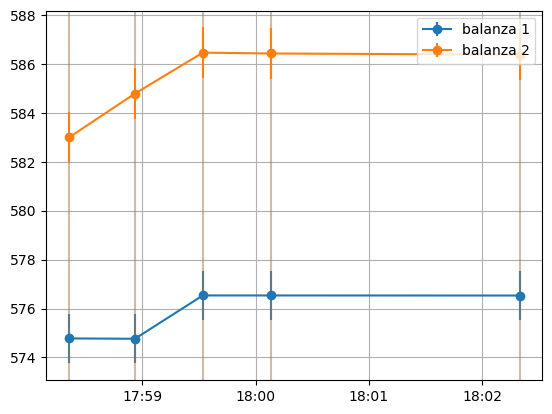

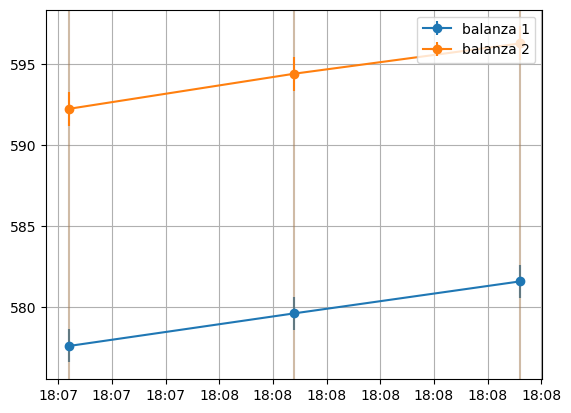

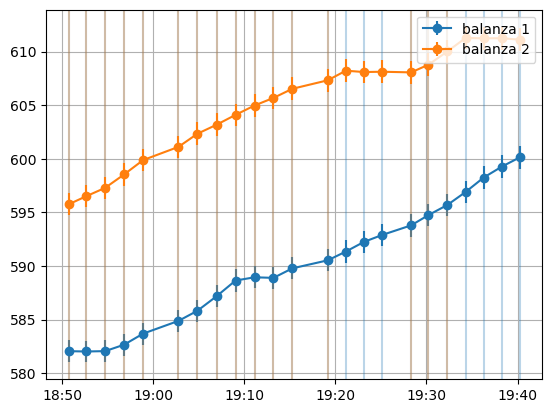

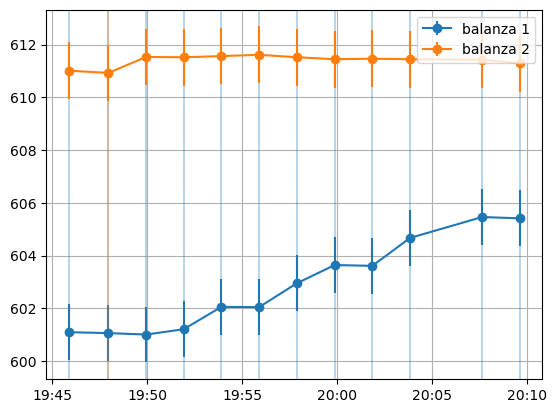

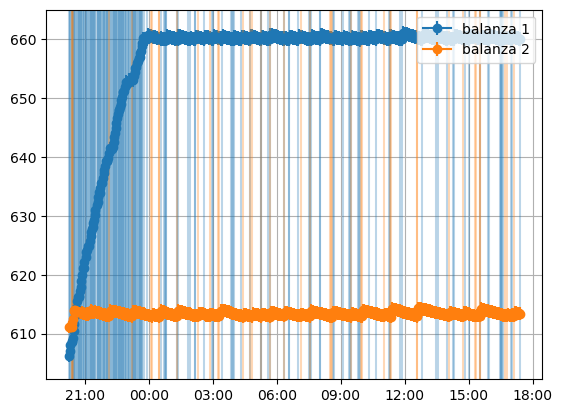

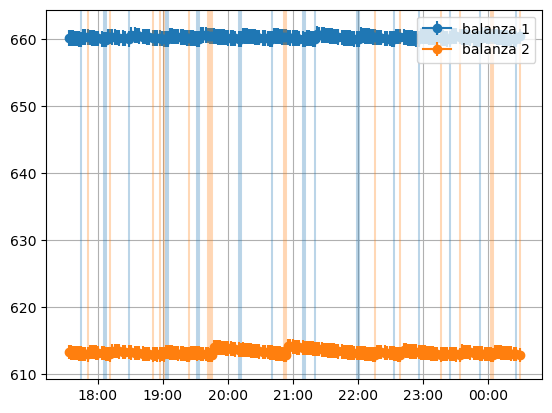

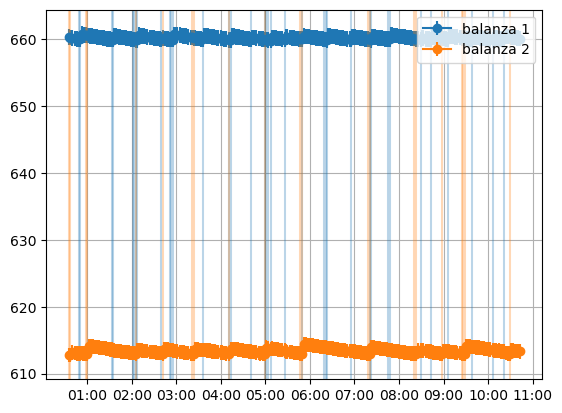

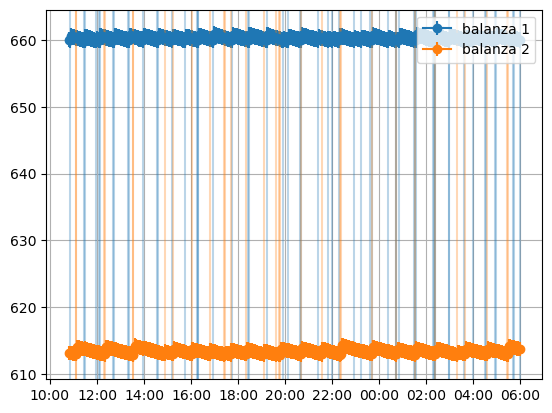

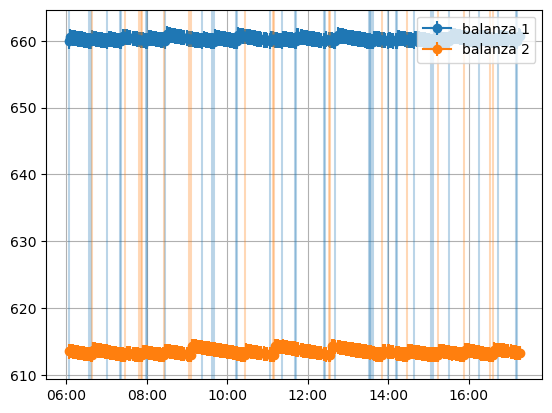

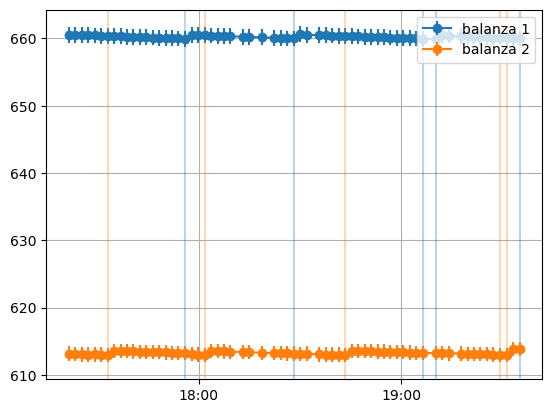

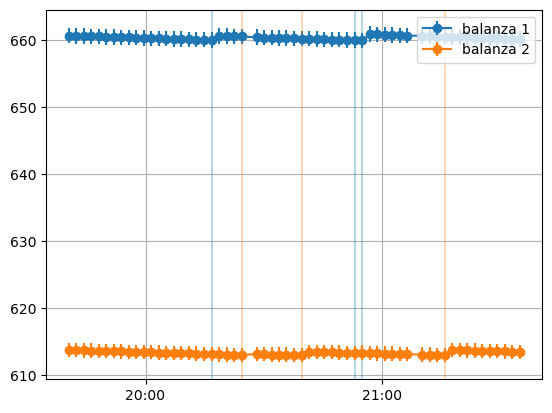

In [31]:
for data in split_data_pd:
    # fig, (ax_top, ax_bottom) = plt.subplots(nrows=1, ncols=1, sharex=True, height_ratios=())
    fig, ax = plt.subplots()
    mat_dates = mdates.date2num(data['datetime'])
    lines = list()
    for n in range(n_balanzas):
        # plot pesos
        line, *_ = ax.errorbar(mat_dates, data[f'balanza_avg_{n+1}'], xerr=0, yerr=data[f'balanza_std_{n+1}'], fmt='-o', label=f'balanza {n+1}')
        lines.append(line)

        # plot riegos
        col = line.get_color()
        for d in data['datetime'].where(data[f'balanza_pump_state_{n+1}'] == 1):
            ax.axvline(mdates.date2num(d), c=col, alpha=.3)
        
        # plot goals
        if f'balanza_goals_{i+1}' in data.columns:
            goal = data[f'balanza_goals_{n+1}']
            if f'balanza_thresholds_{n+1}' in data.columns:
                ax.axhspan(goal - data[f'balanza_thresholds_{i+1}'], goal)
            else:
                ax.axhline(goal)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=1))
    ax.grid(True)

    legend = plt.legend(loc='upper right')
    line_legends = legend.get_lines()
    for l in line_legends:
        l.set_picker(True)
        l.set_pickradius(10)

    graphs = {ll:l for ll, l in zip(line_legends, lines)}

    def on_pick(event):
        legend = event.artist
        is_visible = legend.get_visible()
        
        graphs[legend].set_visible(not is_visible)
        legend.set_visible = not is_visible

        fig.canvas.draw()

    plt.connect('pick_event', on_pick)
    plt.show()




/opt/homebrew/Caskroom/miniconda/base/envs/main/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  func(*args, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/main/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.canvas.print_figure(bytes_io, **kw)


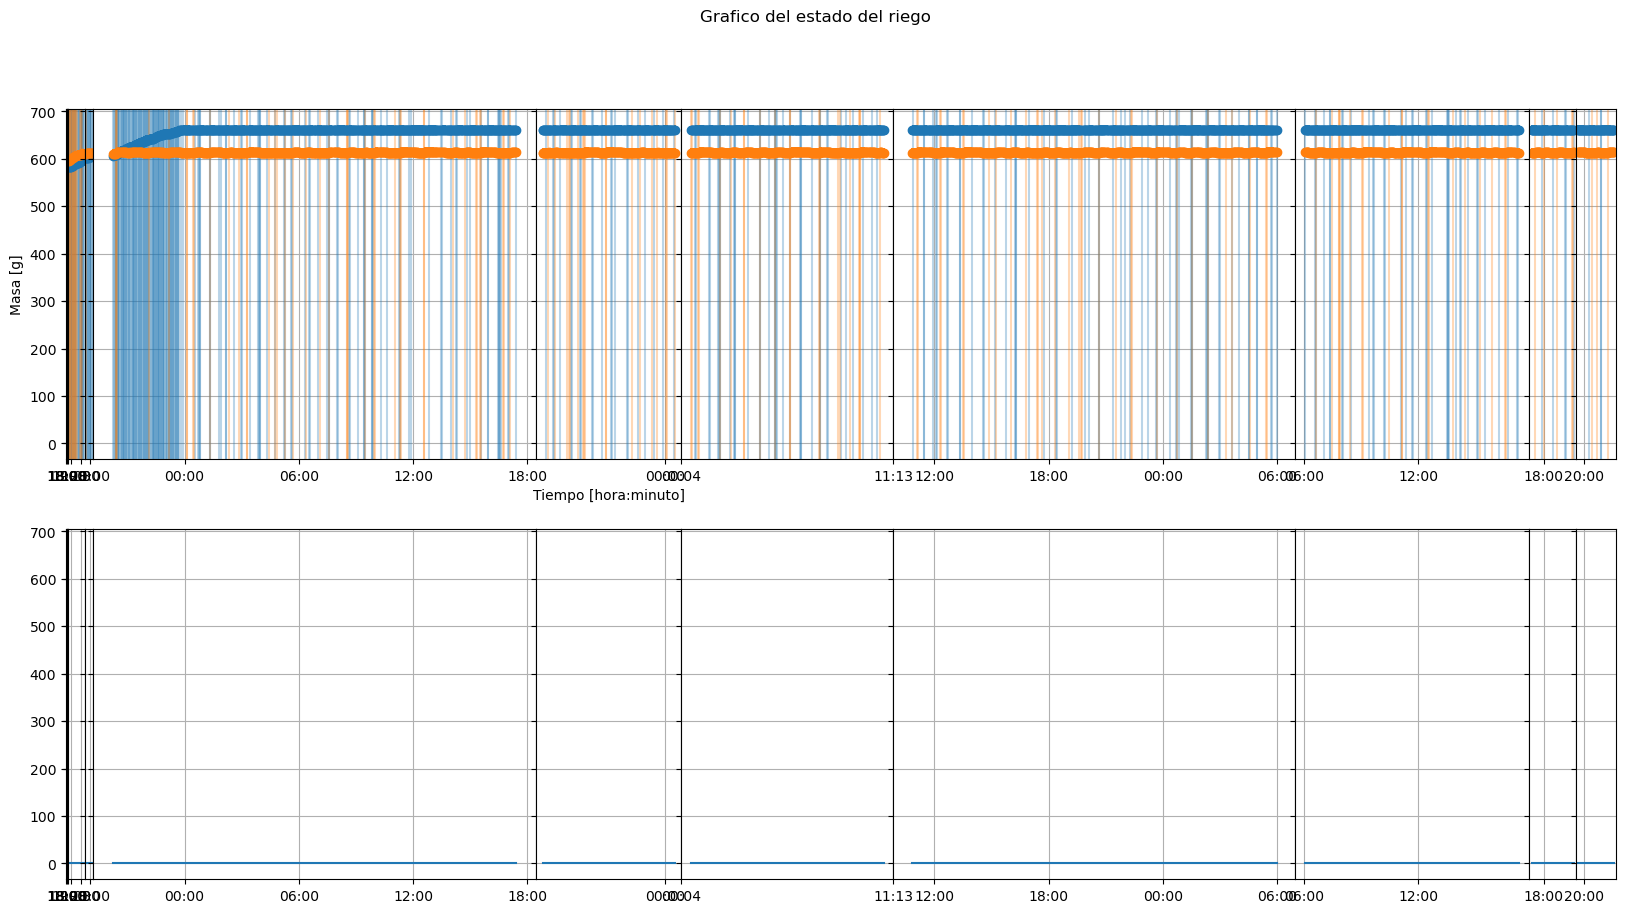

In [24]:
total_x_span = sum((d['epoch'].max() - d['epoch'].min()) for d in split_data_pd)
total_x_ticks = 20
x_relative_spans = [(d['epoch'].max() - d['epoch'].min())/total_x_span for d in split_data_pd]
x_relative_ticks = [max(2, int((span)*20)) for span in x_relative_spans]
fig, axs = plt.subplots(nrows=2, ncols=len(split_data_pd), figsize=(20, 10), sharey=True, width_ratios=x_relative_spans)
plt.subplots_adjust(wspace=.0)
axs = list(zip(*axs))

axs[0][0].set_ylabel('Masa [g]')
axs[int(len(axs)/2)][0].set_xlabel('Tiempo [hora:minuto]')
fig.suptitle('Grafico del estado del riego')
for (data, ax, x_ticks) in zip(split_data_pd, axs, x_relative_ticks):
    mat_dates = mdates.date2num(data['datetime'])
    for i in range(n_balanzas):
        p = ax[0].errorbar(mat_dates, data[f'balanza_avg_{i+1}'], xerr=0, yerr=10, fmt='-o')
        col = p[0].get_color()
        for d in data['datetime'].where(data[f'balanza_pump_state_{i+1}'] == 1):
            ax[0].axvline(mdates.date2num(d), c=col, alpha=.3)
        if f'balanza_goals_{i+1}' in data.columns:
            goal = data[f'balanza_goals_{i+1}']
            if f'balanza_thresholds_{i+1}' in data.columns:
                ax[0].axhspan(goal - data[f'balanza_thresholds_{i+1}'], goal)
            else:
                ax[0].axhline(goal)
    
    ax[1].plot(mat_dates, [0]*len(mat_dates))

    for a in ax:
        a.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        a.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=max(x_ticks, 1), minticks=1))
        a.grid(True)
